# Advanced Pandas Assignment

This assignment will cover many of the pandas methods and functions we have covered and should be a big challenge. We will be working on a cleaned version of our deferred revenue billings and attempt to forecast future recurring billings from our billings history.

Time to get thrown into the pool and see what you can do. Let's see if we can swim together!!!

## Deferred Revenue Billings Classification

The image below describes how we classify billings for the deferred revenue forecast.







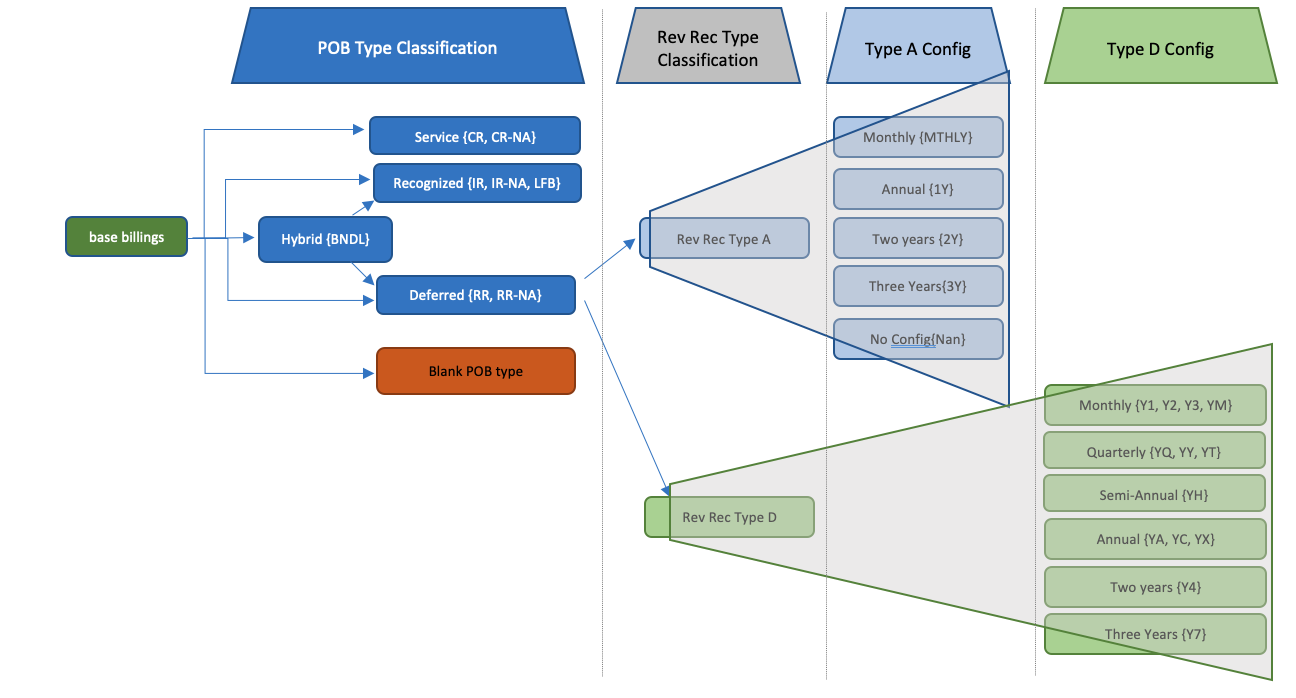


We start with a base_billings file that contains both document currency and USD equivalent billings by currency, business unit and fiscal period. A scrubbed version of this file gets imported below.

### POB Type
POB Type determines how a billing amortizes to revenue. (Michelle, I am talking big picture here and I don't pretend to understand the nuances of this like you do, so please be kind.😊)
 - <b>recognized revenue</b>: Gets booked to revenue immediately and does not go to deferred at all. This is equivalent to a one time sale of perpetual software in a store.
 - <b>service based</b>: These billings are booked to deferred and are reclassified to revenue over the next 12 months as the hours of service are billed.
 - <b>deferred billings</b>: These billings are booked to deferred revenue and amortize over the term of the billing. For monthly billings, these amortize to revenue before the next billing occurs. For annual billings, these billings amortize to revenue smoothly over 12 months.

For now we will ignore the blank POB type as this classification is much more involved.

### Rev Rec Type (In the spreadsheet it is called "Rev Rec Category")
Deferred billings have a revenue recognition type that is either A or D.

#### Type A billings are categorized based on their 'Product Config Type'
The image above indicates the code in curly brackets that corresponds to the frequency of billings and therefore the time it takes for the revenue to amortize.

#### Type D billings are categorized based on their 'Rule for Bill Date'
The image above indicates the codes for the rule for bill date.

### The data includes billings that have been filtered by the following conditions
1. Only EUR and USD billings remain in this dataset.
2. Blank POB types have been removed.
3. Data include periods 1 through 9 of 2020 only.
4. BUNDL billings, which are a combination of deferred and recognized billings have been removed.
5. Deferred billings with blank Rev Rec Category have been removed.
6. Deferred billings with Rev Rec Category A and no product config type (or odd product config types) have been removed.
7. Deferred billings with Rev Rec Category D and no rule for bill date have been removed.
8. We are ignoring the subscription term for the purposes of this exercise (but it is considered for the actual forecast.)


___
## The goal of this exercise is to create a dataframe with the following attributes

#### Row index has three levels
   1. Document Currency (here EUR or USD)
   2. Business Unit (Experience Cloud, Document Cloud, Creative, etc.)
   3. Period (expressed in YYYY-PP format)
   
#### Columns (the suffixes '_DC' and '_US' represent document currency and USD equivalent)
   - 'recognized_DC' billings that are immediately classified as recognized revenue and never hit deferred
   - 'service_DC' billings that are booked to deferred and reclassified to revenue when hours are invoiced
   - 'deferred_1M_DC' document currency billings that are rebilled monthly (and amortize to revenue monthly)
   - 'deferred_3M_DC' document currency billings that are rebilled every 3 months
   - 'deferred_6M_DC' document currency billings that are rebilled every 6 months
   - 'deferred_1Y_DC' document currency billings that are rebilled annually
   - 'deferred_2Y_DC' document currency billings that are rebilled every 2 years
   - 'deferred_3Y_DC' document currency billings that are rebilled every 3 years
   
   
   - 'recognized_US' USD equivalent billings immediately classified as recognized revenue and never hit deferred
   - 'service_US' USD equivalent billings booked to deferred and reclassified to revenue when hours are invoiced
   - 'deferred_1M_US' USD equivalent billings that are rebilled monthly (and amortize to revenue monthly)
   - 'deferred_3M_US' USD equivalent billings that are rebilled every 3 months
   - 'deferred_6M_US' USD equivalent billings that are rebilled every 6 months
   - 'deferred_1Y_US' USD equivalent billings that are rebilled annually
   - 'deferred_2Y_US' USD equivalent billings that are rebilled every 2 years
   - 'deferred_3Y_US' USD equivalent billings that are rebilled every 3 years
___

## Step 0: Import statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

___
## Step 1: Import, check and clean the data

In [2]:
df = pd.read_excel('../data/all_billings_inputs_short.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13347 entries, 0 to 13346
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Document Currency                13347 non-null  object 
 1   Enterprise BU Desc               13347 non-null  object 
 2   Invoice Fiscal Year Period Desc  13347 non-null  object 
 3   POB Type                         13347 non-null  object 
 4   Product Config Type              10322 non-null  object 
 5   Rev Rec Category                 11012 non-null  object 
 6   Rule For Bill Date               7235 non-null   object 
 7   Sales Document Type              13347 non-null  object 
 8   Sales Type                       13347 non-null  object 
 9   Subscription Term                13347 non-null  int64  
 10  Completed Sales ( DC )           13347 non-null  float64
 11  Completed Sales                  13347 non-null  float64
dtypes: float64(2), int

The data (based on the output of the info() method appears to be correctly classified by datatype. Most of the fields are strings, so seeing Dtype = object is correct. We also have 13,347 entries for Document Currency, Enterpricse BU Desc, Invoice Fiscal Year Period Descr, Completed Sales ( DC ) and Completed Sales. So the data appears to be complete.

In [3]:
df.tail()

,Document Currency,Enterprise BU Desc,Invoice Fiscal Year Period Desc,POB Type,Product Config Type,Rev Rec Category,Rule For Bill Date,Sales Document Type,Sales Type,Subscription Term,Completed Sales ( DC ),Completed Sales
13342,USD,Experience Cloud,2020-08,RR,1Y,D,YY,ZLO3,DEFERRED,12,159892.50,159892.50
13343,USD,Document Cloud,2020-09,RR,1Y,D,YY,ZLO5,DEFERRED,0,1575.00,1575.00
13344,USD,Document Cloud,2020-09,RR,1Y,D,YY,ZLG2,DEFERRED,0,-2493.75,-2493.75
13345,USD,Document Cloud,2020-09,RR,1Y,D,YY,ZLO5,DEFERRED,0,2493.75,2493.75
13346,USD,Experience Cloud,2020-09,RR,1Y,D,YY,ZLCR,DEFERRED,12,-237259.83,-237259.83


In [4]:
df.columns

Index(['Document Currency', 'Enterprise BU Desc',
       'Invoice Fiscal Year Period Desc', 'POB Type', 'Product Config Type',
       'Rev Rec Category', 'Rule For Bill Date', 'Sales Document Type',
       'Sales Type', 'Subscription Term', 'Completed Sales ( DC )',
       'Completed Sales'],
      dtype='object')

I will help you clean this database a little by making the column names shorter and to our standard variable naming convention that we have discussed in these tutorials. (That we all stick to all the time... right?🤨)

In [5]:
df.rename(
        index=str,
        columns={
            "Document Currency": "curr",
            "Enterprise BU Desc": "BU",
            "Invoice Fiscal Year Period Desc": "period",
            "POB Type": "POB_type",
            "Product Config Type": "config",
            "Rev Rec Category": "rev_rec_type",
            "Rule For Bill Date": "rebill_rule",
            "Sales Document Type": "sales_doc",
            "Sales Type": "sales_type",
            "Subscription Term": "sub_term",
            "Completed Sales ( DC )": "DC_amount",
            "Completed Sales": "US_amount",
        },
        inplace=True,
    )

In [6]:
df.columns

Index(['curr', 'BU', 'period', 'POB_type', 'config', 'rev_rec_type',
       'rebill_rule', 'sales_doc', 'sales_type', 'sub_term', 'DC_amount',
       'US_amount'],
      dtype='object')

In [7]:
df.head(10)

,curr,BU,period,POB_type,config,rev_rec_type,rebill_rule,sales_doc,sales_type,sub_term,DC_amount,US_amount
0,EUR,Creative,2020-01,CR,1Y,NaN,NaN,ZLG2,DEFERRED,12,-6147.60,-6807.67
1,EUR,Creative,2020-01,CR,1Y,NaN,NaN,ZLO5,DEFERRED,12,104446.44,115782.68
2,EUR,Document Cloud,2020-01,CR,NaN,B,NaN,ZCC,DEFERRED,0,0.00,0.00
3,EUR,Document Cloud,2020-01,CR,NaN,B,NaN,ZPS,DEFERRED,0,1750.00,1944.99
4,EUR,Document Cloud,2020-01,CR,NaN,F,NaN,ZOG2,DEFERRED,0,-1750.00,-1959.41
5,EUR,Document Cloud,2020-01,CR,NaN,B,NaN,ZCC,DEFERRED,0,5000.00,5557.10
6,EUR,Experience Cloud,2020-01,CR,NaN,B,NaN,ZCC,DEFERRED,0,48000.00,52858.56
7,EUR,Experience Cloud,2020-01,CR,OCONS,B,NaN,ZCC,DEFERRED,0,15000.00,16518.30
8,EUR,Experience Cloud,2020-01,CR,OCONS,B,NaN,ZCC,DEFERRED,0,9456.00,10477.63
9,EUR,Experience Cloud,2020-01,CR,NaN,B,NaN,ZATS,DEFERRED,0,4320.00,4801.33


___
## Step 2: Perform initial split of data by POB_type.
We are working with the first split of the data on the upper left part of the image above.

1. <b>Create a list for each of the three revenue recognition types (service, immediate or recognized revenue and deferred) that contain the POB types for that category.</b> Call them list_svc, list_rec, list_def. Use the image above and the POB_type value_counts as a guide to making these three lists

In [8]:
df['POB_type'].value_counts()

RR       10082
IR-NA     1998
IR         670
CR         418
RR-NA      111
CR-NA       67
LFB          1
Name: POB_type, dtype: int64

In [9]:
# I am giving you the first one here.
list_rec = ['IR', 'IR-NA', 'LFB']
list_svc = []
list_def = []

2. Create three dataframes using boolean masks and the lists you created above.

 - df_rec = recognized billings only
 - df_svc = service billings only
 - df_dfr = deferred billings only

##### <font color='red'> Note: We want copies and not a slices</font>

NOTE: There are at least two ways to do this.
1. We can use a series of boolean masks, one for each element of the list and combine them using () and &.
2. We can use a boolean mask and the .isin() method. (HINT: Try this, it is really easier to read!)

In [10]:
# create a dataframe that contains only the recognized billings and label it df_rec


,curr,BU,period,POB_type,config,rev_rec_type,rebill_rule,sales_doc,sales_type,sub_term,DC_amount,US_amount
485,EUR,Creative,2020-01,IR,NaN,NaN,NaN,G2,RECOGNIZED,0,-68.00,-74.88
486,EUR,Creative,2020-01,IR,NaN,NaN,NaN,KE,RECOGNIZED,0,64024.00,70851.80
487,EUR,Creative,2020-01,IR,NaN,NaN,NaN,OR,RECOGNIZED,0,518888.00,573327.59
488,EUR,Creative,2020-01,IR,NaN,NaN,NaN,RE,RECOGNIZED,0,-22862.00,-25365.01
489,EUR,Creative,2020-01,IR,NaN,NaN,NaN,ZCCR,RECOGNIZED,0,-9720.79,-10759.79


In [11]:
# create a dataframe that contains only the service based billings and label it df_svc.


,curr,BU,period,POB_type,config,rev_rec_type,rebill_rule,sales_doc,sales_type,sub_term,DC_amount,US_amount
0,EUR,Creative,2020-01,CR,1Y,NaN,NaN,ZLG2,DEFERRED,12,-6147.60,-6807.67
1,EUR,Creative,2020-01,CR,1Y,NaN,NaN,ZLO5,DEFERRED,12,104446.44,115782.68
2,EUR,Document Cloud,2020-01,CR,NaN,B,NaN,ZCC,DEFERRED,0,0.00,0.00
3,EUR,Document Cloud,2020-01,CR,NaN,B,NaN,ZPS,DEFERRED,0,1750.00,1944.99
4,EUR,Document Cloud,2020-01,CR,NaN,F,NaN,ZOG2,DEFERRED,0,-1750.00,-1959.41


In [12]:
# create a dataframe that contains only the deferred billings and label it df_dfr


,curr,BU,period,POB_type,config,rev_rec_type,rebill_rule,sales_doc,sales_type,sub_term,DC_amount,US_amount
3154,EUR,Creative,2020-01,RR,1Y,A,NaN,ZLO5,DEFERRED,12,17454.31,19339.69
3155,EUR,Creative,2020-01,RR,1Y,A,NaN,ZLO1,DEFERRED,12,402.60,443.36
3156,EUR,Creative,2020-01,RR,1Y,A,NaN,ZLO5,DEFERRED,0,33.18,36.88
3157,EUR,Creative,2020-01,RR,1Y,A,NaN,ZLO5,DEFERRED,12,51012.44,56535.37
3158,EUR,Creative,2020-01,RR,1Y,A,NaN,ZLO5,DEFERRED,0,374.67,415.34
...,...,...,...,...,...,...,...,...,...,...,...,...
13342,USD,Experience Cloud,2020-08,RR,1Y,D,YY,ZLO3,DEFERRED,12,159892.50,159892.50
13343,USD,Document Cloud,2020-09,RR,1Y,D,YY,ZLO5,DEFERRED,0,1575.00,1575.00
13344,USD,Document Cloud,2020-09,RR,1Y,D,YY,ZLG2,DEFERRED,0,-2493.75,-2493.75
13345,USD,Document Cloud,2020-09,RR,1Y,D,YY,ZLO5,DEFERRED,0,2493.75,2493.75


#### Check the dataframes to make sure they have what you would expect.

There are several ways to check the integrity of your new dataframes (df_rec, df_svc and df_drf). Perform a few of these checks in the cells below to verify that the data is what you expect.

In [13]:
# Data Check 1


In [14]:
# Data Check 2


In [15]:
# Data Check 3


___
## Step 3: Group Recognized Revenue 
Recognized revenue billings are one time purchases that are not rebilled. Thus, we do not need any of the other fields to further classify these billings.

#### Group the recognized revenue billings by the following three columns (in this order)
 1. Document Currency (curr)
 2. Business Unit (BU)
 3. Period (period)
#### We want the aggregator function 'aggfunc' to be 'sum()'
 
#### <font color = 'red'> NOTE: When we create a dataframe, the standard is to call the dataframe 'df_something'. When we use groupby on a dataframe and create a grouped dataframe, the standard is too call this object 'gb_something'. Please use this naming convention. It tells the reader that we have a grouped dataframe.</font>

In [16]:
# group the df_rec dataframe by curr, BU and period and call this gb_rec


In [17]:
# print out the gb_rec dataframe
gb_rec

sub_term    DC_amount    US_amount
curr BU                 period                                     
EUR  Creative           2020-01         0   1365949.28   1510651.41
                        2020-02         0   1265748.66   1411041.99
                        2020-03         0   2162419.56   2370023.58
                        2020-04         0   1044554.66   1151671.52
                        2020-05         0   1263494.41   1378238.45
...                                   ...          ...          ...
USD  Print & Publishing 2020-05         0   1656955.97   1656955.97
                        2020-06         0  10336697.21  10336697.21
                        2020-07         0    848661.70    848661.70
                        2020-08         0   1992256.74   1992256.74
                        2020-09         0   6731005.40   6731005.40

[90 rows x 3 columns]

### What do you notice about the other fields (string fields) in the gb_rec dataframe?

When grouping a dataframe, all of the non-numeric fields that are not part of the index are dropped. Pandas has no idea what to do with these strings and cannot use the aggfunc (sum in this case) because this is a calculation.

#### Check that the gb_rec dataframe has the correct amounts for DC_amount and US_amount

In [18]:
# check DC_amount below



In [19]:
# Check US_amount below



#### Clean the gb_rec dataframe by doing the following 
1. Drop the sub_term field
2. Rename DC_amount field to be 'recognized_DC'
3. Rename US_amount field to be 'recognized_US'


In [20]:
# Clean gb_rec




recognized_DC  recognized_US
curr BU       period                               
EUR  Creative 2020-01     1365949.28     1510651.41
              2020-02     1265748.66     1411041.99
              2020-03     2162419.56     2370023.58
              2020-04     1044554.66     1151671.52
              2020-05     1263494.41     1378238.45

___
## Step 4: Group Service Billings

Service billings, like revenue billings are not classified beyond their POB type.

#### Group the service billings by 'curr', 'BU' and 'period' and call this object gb_svc.


In [21]:
# create gb_svc


In [22]:
# view the gb_svc dataframe to make sure it is what you expect
gb_svc

sub_term    DC_amount    US_amount
curr BU                 period                                     
EUR  Creative           2020-01        24     98298.84    108975.01
                        2020-02        24     57127.32     63683.92
                        2020-03        24     98553.00    108075.13
                        2020-04        24     85725.12     94558.40
                        2020-05        24     65494.32     71466.55
                        2020-06        36    103358.64    112309.96
                        2020-07        24     78126.84     87658.42
                        2020-08        24     74350.68     83961.56
                        2020-09        24     93343.68    109869.10
     Document Cloud     2020-01         0      5000.00      5542.68
                        2020-03         0      3433.80      3779.24
                        2020-05         0      8020.00      8727.20
                        2020-06         0      8000.00      8747.84
     Experience Cloud   2020-01         0   1150257.92   1268938.82
                        2020-02         0    889956.00    990068.65
                        2020-03         0    195745.54    209422.43
                        2020-04         0    812973.33    909972.28
                        2020-05         0    232689.63    253465.90
                        2020-06         0    275035.00    298127.17
                        2020-07         0    679833.02    757528.24
                        2020-08         0    538228.75    608240.01
                        2020-09         0    663461.81    791351.03
USD  Creative           2020-01        24     31361.28     31361.28
                        2020-02        12     21137.52     21137.52
                        2020-03        24     36262.44     36262.44
                        2020-04        24     21222.36     21222.36
                        2020-05        12     26715.96     26715.96
                        2020-06        24     43280.88     43280.88
                        2020-07        24     24888.60     24888.60
                        2020-08        36     35200.80     35200.80
                        2020-09        12     37888.44     37888.44
     DX Other           2020-02         0     13800.00     13800.00
                        2020-03         0     18000.00     18000.00
                        2020-04         0     37517.46     37517.46
                        2020-06         0     12000.00     12000.00
                        2020-08         0       -17.46       -17.46
                        2020-09         0    -31500.00    -31500.00
     Document Cloud     2020-01         0     44750.00     44750.00
                        2020-02         0     60000.00     60000.00
                        2020-03         0    341900.00    341900.00
                        2020-04         0     55000.00     55000.00
                        2020-05         0     20000.00     20000.00
                        2020-06         0     50000.00     50000.00
                        2020-07         0     60000.00     60000.00
                        2020-08         0    145000.00    145000.00
                        2020-09         0    -22500.00    -22500.00
     Experience Cloud   2020-01         0  23983106.40  23983106.40
                        2020-02         0  15563924.65  15563924.65
                        2020-03         0   9138185.40   9138185.40
                        2020-04         0  16217952.45  16217952.45
                        2020-05         0  14314534.50  14314534.50
                        2020-06         0   7109194.36   7109194.36
                        2020-07         0   7936404.89   7936404.89
                        2020-08         0   5410243.32   5410243.32
                        2020-09         0   7298703.00   7298703.00
     Print & Publishing 2020-01         0     35000.00     35000.00
                        2020-02         0     33333.00     33333.00
                     

In [ ]:
# Check that the totals match what you expect
# Check DC


In [ ]:
# Check USD


### Clean the gb_svc dataframe by doing the following
1. Drop the sub_term field
2. Rename DC_amount to 'service_DC'
3. Rename the US_amount to be 'service_US'

In [23]:
# clean gb_svc



service_DC  service_US
curr BU       period                         
EUR  Creative 2020-01    98298.84   108975.01
              2020-02    57127.32    63683.92
              2020-03    98553.00   108075.13
              2020-04    85725.12    94558.40
              2020-05    65494.32    71466.55

## Step 5: Join the service (gb_svc) and recognized revenue billings (gb_rec) and name the resulting dataframe 'df_billings'

Later we will add the deferred billings to this dataframe and it will contain all of our billings.

#### NOTE: Not all business units have service based billings, so our indicies are not completely the same!
This is the case with the Adobe's real billings and most datasets, so it is good practice to use outer joins.

##### NOTE: When using outerjoins, you may need to fill in NA values for the dollar amounts.

In [28]:
df_billings

service_DC  service_US  recognized_DC  \
curr BU                 period                                           
EUR  Creative           2020-01    98298.84   108975.01     1365949.28   
                        2020-02    57127.32    63683.92     1265748.66   
                        2020-03    98553.00   108075.13     2162419.56   
                        2020-04    85725.12    94558.40     1044554.66   
                        2020-05    65494.32    71466.55     1263494.41   
...                                     ...         ...            ...   
USD  Print & Publishing 2020-05         NaN         NaN     1656955.97   
                        2020-06    50000.00    50000.00    10336697.21   
                        2020-07         NaN         NaN      848661.70   
                        2020-08         NaN         NaN     1992256.74   
                        2020-09         NaN         NaN     6731005.40   

                                 recognized_US  
curr BU                 period                  
EUR  Creative           2020-01     1510651.41  
                        2020-02     1411041.99  
                        2020-03     2370023.58  
                        2020-04     1151671.52  
                        2020-05     1378238.45  
...                                        ...  
USD  Print & Publishing 2020-05     1656955.97  
                        2020-06    10336697.21  
                        2020-07      848661.70  
                        2020-08     1992256.74  
                        2020-09     6731005.40  

[90 rows x 4 columns]

In [29]:
# fill in the NAN values
df_billings = df_billings.fillna(0)
df_billings.tail(10)

service_DC  service_US  recognized_DC  \
curr BU                 period                                           
USD  LiveCycle          2020-09         0.0         0.0       39341.57   
     Print & Publishing 2020-01     35000.0     35000.0     1016593.80   
                        2020-02     33333.0     33333.0     6806243.20   
                        2020-03         0.0         0.0     6369245.97   
                        2020-04     33333.0     33333.0      684593.15   
                        2020-05         0.0         0.0     1656955.97   
                        2020-06     50000.0     50000.0    10336697.21   
                        2020-07         0.0         0.0      848661.70   
                        2020-08         0.0         0.0     1992256.74   
                        2020-09         0.0         0.0     6731005.40   

                                 recognized_US  
curr BU                 period                  
USD  LiveCycle          2020-09       39341.57  
     Print & Publishing 2020-01     1016593.80  
                        2020-02     6806243.20  
                        2020-03     6369245.97  
                        2020-04      684593.15  
                        2020-05     1656955.97  
                        2020-06    10336697.21  
                        2020-07      848661.70  
                        2020-08     1992256.74  
                        2020-09     6731005.40

___
## Step 6: Split deferred billings based on Revenue Recognition Type Classification

Create two dataframes df_dfr_a and df_dfr_d that contain the deferred revenue billings that have rev_rec_type equal to A and D respectively. (Make sure that they are a copy and not a slice.)

In [ ]:
# create df_dfr_a using a boolean mask


In [ ]:
# create df_dfr_d using a boolean mask


In [ ]:
# check that the DC_amount of df_dfr matches the sum of df_dfr_a and df_dfr_d


In [ ]:
# check that the US_amount of df_dfr matches the sum of df_dfr_a and df_dfr_d


## Step 7: Classify the type A deferred billings

The type A deferred billings can now be classified based on the 'config' column. 
 - Create df_dfr_a_1M that contains the 'MTHLY' rec_rec_type
 - Create df_dfr_a_1Y that contains the '1Y' rec_rec_type
 - Create df_dfr_a_2Y that contains the '2Y' rec_rec_type
 - Create df_dfr_a_3Y that contains the '3Y' rec_rec_type
 
### Note: Make sure these are copies and not a slice of df_dfr

In [ ]:
# create df_dfr_a_1M


In [ ]:
# create df_dfr_a_1Y


In [ ]:
# create df_dfr_a_2Y


In [ ]:
# create df_dfr_a_3Y


### Group these dataframes by 'curr', 'BU' and 'period'
Now that we know how these type A deferred billings are being rebilled, we do not need any of the additional information about these billings (none of the other string columns) besides the currency, BU and period.

Label these grouped dataframes gb_a_1M, gb_a_1Y, gb_a_2Y and gb_a_3Y.

In [ ]:
# create gb_a_1M


In [ ]:
# create gb_a_1Y


In [ ]:
# create gb_a_2Y


In [ ]:
# create gb_a_3Y


### Rename the US_amount and DC_amount of these grouped dataframes and drop sub_term field

gb_a_1M:
- deferred_1M_DC and deferred_1M_US

gb_a_1Y:
- deferred_1Y_DC and deferred_1Y_US

gb_a_2Y:
- deferred_2Y_DC and deferred_2Y_US

gb_a_3Y:
- deferred_3Y_DC and deferred_3Y_US


In [ ]:
# rename gb_a_1M columns


In [ ]:
# rename gb_a_1Y columns


In [ ]:
# rename gb_a_2Y columns


In [ ]:
# rename gb_a_3Y colums


### JOIN the gb_a dataframes

The 4 type_A deferred dataframes (gb_a_#A) can now be joined together. They all have the same index ('curr', 'BU', 'period')
so we can use the join method. Start by joining gb_a_1M with gb_a_1Y and print the results of the merged dataframe (or use head, tail or sample).


In [ ]:
# create df_a = gb_a_1M joined with gb_a_1Y


In [ ]:
# check the output of df_a


In [ ]:
# join df_a with gb_a_2Y and keep the name df_a


In [ ]:
# check the output of df_a


In [ ]:
# join df_a with gb_a_3Y and keep the name df_a


In [ ]:
# check the output of df_a


___
## Step 8: Classify the type D billings

The type D deferred billings need to be classified based on their rebill_rule field.

From the lists below create the following dataframes
 - df_dfr_d_1M
 - df_dfr_d_3M
 - df_dfr_d_6M
 - df_dfr_d_1Y
 - df_dfr_d_2Y
 - df_dfr_d_3Y

In [ ]:
# lists to use to create dataframes
list_1M = ['Y1', 'Y2', 'Y3', 'YM']
list_3M = ['YQ', 'YY', 'YT']
list_6M = ['YH']
list_1Y = ['YA', 'YC', 'YX']
list_2Y = ['Y4']
list_3Y = ['Y7']

In [ ]:
# df_dfr_d_1M


In [ ]:
# df_dfr_d_3M


In [ ]:
# df_dfr_d_6M


In [ ]:
# df_dfr_d_1Y


In [ ]:
# df_dfr_d_2Y


In [ ]:
# df_dfr_d_3Y


### Group each of these dataframes by 'curr', 'BU' and 'period'

In [ ]:
# gb_d_1M


In [ ]:
# gb_d_3M


In [ ]:
# gb_d_6M


In [ ]:
# gb_d_1Y


In [ ]:
# gb_d_2Y


In [ ]:
# gb_d_3Y


### Remove the sub_term field from each of the gb_d_## dataframes

### Rename the US_amount and DC_amount of these grouped dataframes

gb_d_1M:
- deferred_1M_DC and deferred_1M_US

gb_d_3M:
- deferred_3M_DC and deferred_3M_US

gb_d_6M:
- deferred_6M_DC and deferred_6M_US

gb_d_1Y:
- deferred_1Y_DC and deferred_1Y_US

gb_d_2Y:
- deferred_2Y_DC and deferred_2Y_US

gb_d_3Y:
- deferred_3Y_DC and deferred_3Y_US


### Join these dataframes into one dataframe df_d


## Step 9: Join the df_a and df_d dataframes and name the resulting dataframe df_deferred
They both have the same 3-level index, so they can be joined.

##### NOTE: The dataframes have several columns that are not in the index and are common across the dataframes. Make sure you use a suffix when joining these dataframes.
For the purposes of this exercise let the suffix for df_a = a and the suffix for df_d = d.


### Clean the columns
Since both type A and type D deferred billing may contain the same rebill frequency, we have duplicate column names.

For example: deferred_1M_a_DC and deferred_1M_d_DC both contain one-month deferred billings in document currency.

Create a new column, 'deferred_1M_DC' in this case, that is the sum of deferred_1M_a_DC and deferred_1M_b_DC.

Then drop deferred_1M_a_DC and deferred_1M_d_DC.

Do this for all of the columns that are duplicated based on having both a type A and type D with the same rebill frequency.

## Step 10: Join the df_billings dataframe with the df_deferred dataframe 

We should not have any duplicate columns here so we do not need lsuffix and rsuffix.

Make sure to use an outer join and then fill any Nans with zero.


##### Check that the resulting dataframe contains what you expect.